## Import Library

In [ ]:
import os
import json
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, cross_val_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, confusion_matrix,
    classification_report, f1_score, precision_recall_curve, average_precision_score,
)
import joblib
from catboost import CatBoostClassifier
from IPython.display import display

warnings.filterwarnings('ignore', category=UserWarning)

project_path = "E:/Project/HepatitisC-Prediction/"
file_path = f"{project_path}/Dataset/cleaned_dataset.csv"
result_path = f"{project_path}/Result"
hyper_path = f"{result_path}/Hyperparameter"
model_path = f"{project_path}/Models"

## Load Dataset

In [6]:
df = pd.read_csv(file_path)
print(df.shape)
print(df.info())

(3687, 30)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  3687 non-null   int64  
 1   gender               3687 non-null   int64  
 2   race_ethnicity       3687 non-null   int64  
 3   marital_status       3687 non-null   int64  
 4   jaundice_history     3687 non-null   int64  
 5   receive_transfusion  3687 non-null   int64  
 6   liver_condition      3687 non-null   int64  
 7   injectable_drug_use  3687 non-null   int64  
 8   drug_use             3687 non-null   int64  
 9   alcohol_consumption  3687 non-null   int64  
 10  alt                  3687 non-null   float64
 11  albumin              3687 non-null   float64
 12  alp                  3687 non-null   float64
 13  ast                  3687 non-null   float64
 14  bun                  3687 non-null   float64
 15  cholesterol          3687 n

In [7]:
df_train = df[df['dataset'] == 'train']
df_test = df[df['dataset'] == 'test']

X_train = df_train.drop(columns=['hcv_status', 'dataset'])
y_train = df_train['hcv_status']

X_test = df_test.drop(columns=['hcv_status', 'dataset'])
y_test = df_test['hcv_status']

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (3198, 28)
Test shape: (489, 28)


In [ ]:
numeric_features_to_scale = ['age', 'alt', 'albumin', 'alp', 'ast', 'bun', 'cholesterol', 'cpk', 'creatinine', 'ggt', 'glucose', 'total_bilirubin', 'total_calcium', 'total_protein', 'triglycerides', 'uric_acid', 'ldh', 'globulin', 'osmolality']
categorical_features = ['gender', 'education_level', 'receive_transfusion', 'liver_condition', 'injectable_drug_use', 'drug_use', 'alcohol_consumption']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_to_scale)
    ],
    remainder='passthrough'
)

scaled_x_train = preprocessor.fit_transform(X_train)
scaled_x_test = preprocessor.transform(X_test)

os.makedirs(model_path, exist_ok=True)
joblib.dump(preprocessor, f"{model_path}/scaler.joblib")

print(f"Scaled X_train shape: {scaled_x_train.shape}")
print(f"Scaled X_test shape: {scaled_x_test.shape}")

Scaled X_train shape: (3198, 28)
Scaled X_test shape: (489, 28)


## Hyperparameter Tuning - CatBoost dengan GridSearchCV (5-Fold CV)

In [9]:
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}

catboost_model = CatBoostClassifier(
    random_state=42,
    silent=True,
    allow_writing_files=False
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Parameter Grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
    
total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal kombinasi parameter: {total_combinations}")
print(f"Total fits yang akan dilakukan: {total_combinations * 5} (5-fold CV)")

Parameter Grid:
  iterations: [100, 200, 300]
  learning_rate: [0.01, 0.05, 0.1]
  depth: [4, 6, 8]
  l2_leaf_reg: [1, 3, 5]
  border_count: [32, 64, 128]

Total kombinasi parameter: 243
Total fits yang akan dilakukan: 1215 (5-fold CV)


In [10]:
print("Memulai GridSearchCV untuk CatBoost...")
print("=" * 60)

grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search.fit(scaled_x_train, y_train)

print("\n" + "=" * 60)
print("GridSearchCV Selesai!")
print("=" * 60)

Memulai GridSearchCV untuk CatBoost...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

GridSearchCV Selesai!


## Hasil GridSearchCV

In [11]:
print("=" * 60)
print("HASIL HYPERPARAMETER TUNING - CATBOOST")
print("=" * 60)

print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation ROC AUC Score: {grid_search.best_score_:.4f}")

os.makedirs(hyper_path, exist_ok=True)
best_params = grid_search.best_params_
best_params['best_cv_score'] = grid_search.best_score_

with open(f"{hyper_path}/catboost_best_params.json", 'w') as f:
    json.dump(best_params, f, indent=4)
    
print(f"\nBest parameters disimpan ke: {hyper_path}/catboost_best_params.json")

HASIL HYPERPARAMETER TUNING - CATBOOST

Best Parameters:
  border_count: 32
  depth: 6
  iterations: 300
  l2_leaf_reg: 1
  learning_rate: 0.1

Best Cross-Validation ROC AUC Score: 0.9974

Best parameters disimpan ke: E:/Project/HepatitisC-Prediction//Hyperparameter/catboost_best_params.json


In [12]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

columns_to_show = ['params', 'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'rank_test_score']
cv_results_sorted = cv_results_df[columns_to_show].sort_values('rank_test_score')

print("Top 10 Kombinasi Parameter:")
display(cv_results_sorted.head(10))

Top 10 Kombinasi Parameter:


,params,mean_test_score,std_test_score,mean_train_score,std_train_score,rank_test_score
47,"{'border_count': 32, 'depth': 6, 'iterations':...",0.997360,0.000870,1.0,0.0,1
38,"{'border_count': 32, 'depth': 6, 'iterations':...",0.997327,0.000959,1.0,0.0,2
46,"{'border_count': 32, 'depth': 6, 'iterations':...",0.997324,0.000776,1.0,0.0,3
50,"{'border_count': 32, 'depth': 6, 'iterations':...",0.997271,0.000805,1.0,0.0,4
209,"{'border_count': 128, 'depth': 6, 'iterations'...",0.997244,0.000873,1.0,0.0,5
134,"{'border_count': 64, 'depth': 6, 'iterations':...",0.997244,0.000780,1.0,0.0,6
146,"{'border_count': 64, 'depth': 8, 'iterations':...",0.997166,0.000800,1.0,0.0,7
155,"{'border_count': 64, 'depth': 8, 'iterations':...",0.997154,0.000782,1.0,0.0,8
127,"{'border_count': 64, 'depth': 6, 'iterations':...",0.997141,0.000711,1.0,0.0,9
131,"{'border_count': 64, 'depth': 6, 'iterations':...",0.997131,0.000893,1.0,0.0,10


## Evaluasi Model dengan Best Parameters pada Test Set

In [13]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(scaled_x_test)
y_pred_proba = best_model.predict_proba(scaled_x_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

print("=" * 60)
print("EVALUASI MODEL CATBOOST (TUNED) PADA TEST SET")
print("=" * 60)
print(f"\nAccuracy:          {accuracy:.4f}")
print(f"F1 Score:          {f1:.4f}")
print(f"ROC AUC:           {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

EVALUASI MODEL CATBOOST (TUNED) PADA TEST SET

Accuracy:          0.9591
F1 Score:          0.8901
ROC AUC:           0.9939
Average Precision: 0.9745

Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.97      0.97       401
    Positive       0.86      0.92      0.89        88

    accuracy                           0.96       489
   macro avg       0.92      0.94      0.93       489
weighted avg       0.96      0.96      0.96       489



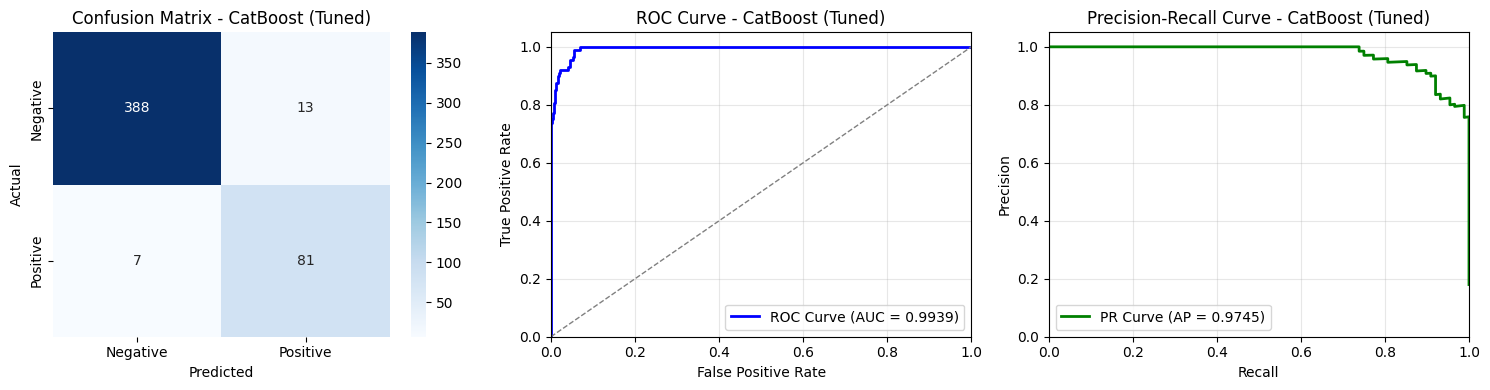

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
axes[0].set_title('Confusion Matrix - CatBoost (Tuned)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - CatBoost (Tuned)')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
axes[2].plot(recall, precision, color='green', lw=2, label=f'PR Curve (AP = {avg_precision:.4f})')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve - CatBoost (Tuned)')
axes[2].legend(loc='lower left')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Cross-Validation Scores per Fold

CROSS-VALIDATION SCORES (5-FOLD) - MODEL TERBAIK
Fold 1: ROC AUC = 0.9962
Fold 2: ROC AUC = 0.9983
Fold 3: ROC AUC = 0.9983
Fold 4: ROC AUC = 0.9976
Fold 5: ROC AUC = 0.9965

Mean ROC AUC: 0.9974
Std ROC AUC:  0.0009


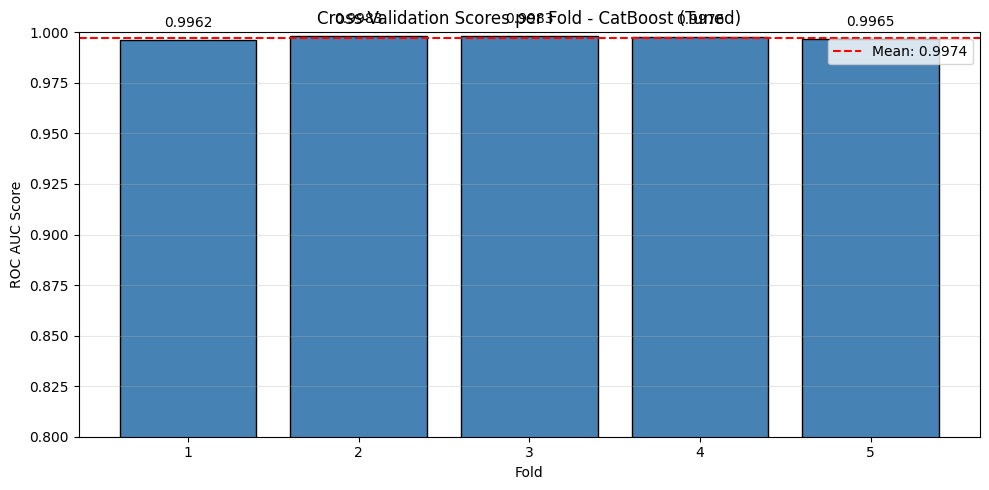

In [15]:
cv_scores = cross_val_score(best_model, scaled_x_train, y_train, cv=cv, scoring='roc_auc')

print("=" * 60)
print("CROSS-VALIDATION SCORES (5-FOLD) - MODEL TERBAIK")
print("=" * 60)

for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: ROC AUC = {score:.4f}")

print(f"\nMean ROC AUC: {cv_scores.mean():.4f}")
print(f"Std ROC AUC:  {cv_scores.std():.4f}")

plt.figure(figsize=(10, 5))
bars = plt.bar(range(1, 6), cv_scores, color='steelblue', edgecolor='black')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('ROC AUC Score')
plt.title('Cross-Validation Scores per Fold - CatBoost (Tuned)')
plt.xticks(range(1, 6))
plt.ylim([0.8, 1.0])
plt.legend()
plt.grid(axis='y', alpha=0.3)

for bar, score in zip(bars, cv_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{score:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Simpan Model Terbaik

In [16]:
os.makedirs(model_path, exist_ok=True)
joblib.dump(best_model, f"{model_path}/catboost_tuned.joblib")

evaluation_results = {
    'best_params': grid_search.best_params_,
    'cv_score': grid_search.best_score_,
    'test_metrics': {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'average_precision': avg_precision
    },
    'cv_scores_per_fold': cv_scores.tolist(),
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std()
}

os.makedirs(f"{result_path}/CatBoost_Tuned", exist_ok=True)
with open(f"{result_path}/CatBoost_Tuned/CatBoost_tuned_evaluation.json", 'w') as f:
    json.dump(evaluation_results, f, indent=4)

print("=" * 60)
print("MODEL DAN HASIL DISIMPAN")
print("=" * 60)
print(f"\nModel disimpan ke: {model_path}/catboost_tuned.joblib")
print(f"Hasil evaluasi disimpan ke: {result_path}/CatBoost_Tuned/CatBoost_tuned_evaluation.json")
print(f"Best parameters disimpan ke: {hyper_path}/catboost_best_params.json")

MODEL DAN HASIL DISIMPAN

Model disimpan ke: E:/Project/HepatitisC-Prediction//Models/catboost_tuned.joblib
Hasil evaluasi disimpan ke: E:/Project/HepatitisC-Prediction//Result/CatBoost_Tuned/CatBoost_tuned_evaluation.json
Best parameters disimpan ke: E:/Project/HepatitisC-Prediction//Hyperparameter/catboost_best_params.json


## Ringkasan Akhir

In [17]:
print("=" * 70)
print("RINGKASAN HYPERPARAMETER TUNING - CATBOOST")
print("=" * 70)

print("\n📊 BEST PARAMETERS:")
for param, value in grid_search.best_params_.items():
    print(f"   • {param}: {value}")

print(f"\n📈 PERFORMANCE METRICS:")
print(f"   Cross-Validation (5-Fold):")
print(f"      • Mean ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"\n   Test Set:")
print(f"      • Accuracy:          {accuracy:.4f}")
print(f"      • F1 Score:          {f1:.4f}")
print(f"      • ROC AUC:           {roc_auc:.4f}")
print(f"      • Average Precision: {avg_precision:.4f}")

print("\n" + "=" * 70)
print("HYPERPARAMETER TUNING SELESAI!")
print("=" * 70)

RINGKASAN HYPERPARAMETER TUNING - CATBOOST

📊 BEST PARAMETERS:
   • border_count: 32
   • depth: 6
   • iterations: 300
   • l2_leaf_reg: 1
   • learning_rate: 0.1
   • best_cv_score: 0.9973595770474137

📈 PERFORMANCE METRICS:
   Cross-Validation (5-Fold):
      • Mean ROC AUC: 0.9974 ± 0.0009

   Test Set:
      • Accuracy:          0.9591
      • F1 Score:          0.8901
      • ROC AUC:           0.9939
      • Average Precision: 0.9745

HYPERPARAMETER TUNING SELESAI!
